# Implémentez un modèle de scoring

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 
Les données

Voici les données dont vous aurez besoin pour réaliser le dashboard. Pour plus de simplicité, vous pouvez les télécharger à cette adresse.

Vous aurez sûrement besoin de joindre les différentes tables entre elles.

Votre mission

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# bokeh basics
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

pd.set_option('display.max_columns', 200) #Pour avoir accès à toutes les colonnes dans la méthode display

In [2]:
# ma fonction favorite
def df_properties(df):
    import time
    t = time.time()
    data = pd.DataFrame(index = ['object','count','% count','unique'], columns = df.columns) 
    
    for col in df.columns:
        data.loc[:,col]=[df[col].dtypes,df[col].count(),df[col].count()/len(df)*100,df[col].nunique()]
    print('creating df took',time.time()-t,'seconds')    

    return data

# Chargement des données

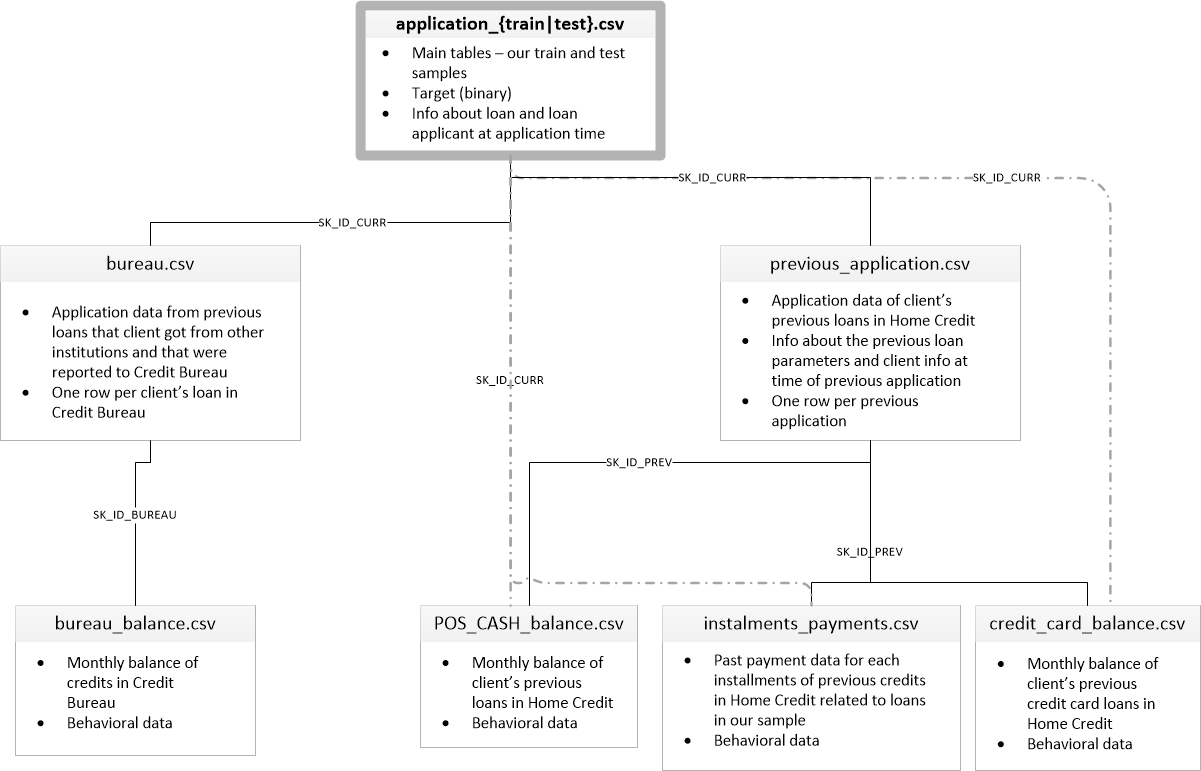

In [3]:
application_test = pd.read_csv('home-credit-default-risk/application_test.csv')
application_train = pd.read_csv('home-credit-default-risk/application_train.csv')
bureau_balance = pd.read_csv('home-credit-default-risk/bureau_balance.csv')
bureau = pd.read_csv('home-credit-default-risk/bureau.csv')
credit_card_balance = pd.read_csv('home-credit-default-risk/credit_card_balance.csv')
columns_description = pd.read_csv('home-credit-default-risk/HomeCredit_columns_description.csv',index_col = 0)
installments_payments = pd.read_csv('home-credit-default-risk/installments_payments.csv')
POS_CASH_balance = pd.read_csv('home-credit-default-risk/POS_CASH_balance.csv')
previous_application = pd.read_csv('home-credit-default-risk/previous_application.csv')

## Description des colonnes 

In [4]:
columns_description

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


## Application train

In [5]:
application_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
104219,220960,0,Cash loans,F,N,N,0,135000.0,239850.0,25578.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.007274,-15637,-451,-771.0,-2093,NaN,1,1,0,1,1,0,Medicine staff,2.0,2,2,MONDAY,12,1,1,0,1,1,0,Medicine,0.744721,0.750651,0.047601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-757.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
51326,159431,0,Cash loans,F,N,Y,0,180000.0,1035000.0,33516.0,1035000.0,Children,Working,Higher education,Married,House / apartment,0.030755,-10285,-2866,-1725.0,-2201,NaN,1,1,0,1,0,0,Managers,2.0,2,2,MONDAY,17,0,0,0,0,0,0,Medicine,0.565223,0.565763,0.117614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1524.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
41338,147863,0,Cash loans,F,N,Y,0,121500.0,405000.0,22099.5,405000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.014520,-10348,-603,-5008.0,-286,NaN,1,1,0,1,0,1,NaN,2.0,2,2,MONDAY,7,0,0,0,0,0,0,Business Entity Type 3,0.341278,0.333396,NaN,0.0814,NaN,0.9727,NaN,NaN,0.0,0.1379,0.1667,NaN,0.0000,NaN,0.0525,NaN,0.0274,0.0830,NaN,0.9727,NaN,NaN,0.0,0.1379,0.1667,NaN,0.0000,NaN,0.0546,NaN,0.0290,0.0822,NaN,0.9727,NaN,NaN,0.0,0.1379,0.1667,NaN,0.0000,NaN,0.0534,NaN,0.0280,NaN,block of flats,0.0472,"Stone, brick",No,1.0,0.0,1.0,0.0,-1917.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
252965,392713,0,Cash loans,M,N,Y,0,76500.0,495000.0,19759.5,495000.0,Una

In [6]:
df_properties(application_train)

creating df took 1.6239101886749268 seconds


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
object,int64,int64,object,object,object,object,int64,float64,float64,float64,float64,object,object,object,object,object,float64,int64,int64,float64,int64,float64,int64,int64,int64,int64,int64,int64,object,float64,int64,int64,object,int64,int64,int64,int64,int64,int64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,object,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64
count,307511,307511,307511,307511,307511,307511,307511,307511,307511,307499,307233,306219,307511,307511,307511,307511,307511,307511,307511,307511,307511,104582,307511,307511,307511,307511,307511,307511,211120,307509,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,134133,306851,246546,151450,127568,157504,103023,92646,143620,152683,154491,98869,124921,97312,153161,93997,137829,151450,127568,157504,103023,92646,143620,152683,154491,98869,124921,97312,153161,93997,137829,151450,127568,157504,103023,92646,143620,152683,154491,98869,124921,97312,153161,93997,137829,97216,153214,159080,151170,161756,306490,306490,306490,306490,307510,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,265992,265992,265992,265992,265992,265992
% count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,99.9

- target = TARGET

In [7]:
columns_description.loc[columns_description.Row.str.contains('FLAG_DOC')]

,Table,Row,Description,Special
99,application_{train|test}.csv,FLAG_DOCUMENT_2,Did client provide document 2,NaN
100,application_{train|test}.csv,FLAG_DOCUMENT_3,Did client provide document 3,NaN
101,application_{train|test}.csv,FLAG_DOCUMENT_4,Did client provide document 4,NaN
102,application_{train|test}.csv,FLAG_DOCUMENT_5,Did client provide document 5,NaN
103,application_{train|test}.csv,FLAG_DOCUMENT_6,Did client provide document 6,NaN
104,application_{train|test}.csv,FLAG_DOCUMENT_7,Did client provide document 7,NaN
105,application_{train|test}.csv,FLAG_DOCUMENT_8,Did client provide document 8,NaN
106,application_{train|test}.csv,FLAG_DOCUMENT_9,Did client provide document 9,NaN
107,application_{train|test}.csv,FLAG_DOCUMENT_10,Did client provide document 10,NaN
108,application_{train|test}.csv,FLAG_DOCUMENT_11,Did client provide document 11,NaN


In [8]:
columns_description.loc[columns_description.Row.str.contains('AMT')]

,Table,Row,Description,Special
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
13,application_{train|test}.csv,AMT_GOODS_PRICE,For consumer loans it is the price of the good...,NaN
119,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_HOUR,Number of enquiries to Credit Bureau about the...,NaN
120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN
124,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_YEAR,Number of enquiries to Credit Bureau about the...,NaN


## Bureau

In [9]:
bureau.sample(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1019643,239155,5969032,Closed,currency 1,-2524,0,-2261.0,-2260.0,NaN,0,35005.5,0.000,NaN,0.0,Consumer credit,-923,0.0
65333,174810,5004478,Active,currency 1,-699,0,27219.0,NaN,0.0,0,90000.0,77375.385,12624.615,0.0,Credit card,-28,4500.0


In [10]:
df_properties(bureau)

creating df took 1.5473711490631104 seconds


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
object,int64,int64,object,object,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,object,int64,float64
count,1716428,1716428,1716428,1716428,1716428,1716428,1610875,1082775,591940,1716428,1716415,1458759,1124648,1716428,1716428,1716428,489637
% count,100.0,100.0,100.0,100.0,100.0,100.0,93.850427,63.083042,34.486736,100.0,99.999243,84.988068,65.522585,100.0,100.0,100.0,28.52651
unique,305811,1716428,4,4,2923,942,14096,2917,68251,10,236708,226537,51726,1616,15,2982,40321


In [11]:
bureau_balance.sample(2)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
375064,5828923,-21,C
19906501,5645459,-15,X


In [12]:
df_properties(bureau_balance)

creating df took 5.1893470287323 seconds


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
object,int64,int64,object
count,27299925,27299925,27299925
% count,100.0,100.0,100.0
unique,817395,97,8


## Previous Application

In [13]:
previous_application.sample(2)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
148494,1073769,178709,Cash loans,NaN,0.0,0.0,NaN,NaN,SUNDAY,13,Y,1,NaN,NaN,NaN,XNA,Refused,-347,XNA,HC,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
403355,1856378,154034,Cash loans,9399.42,225000.0,284400.0,NaN,225000.0,THURSDAY,17,Y,1,NaN,NaN,NaN,XNA,Approved,-358,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,48.0,low_normal,Cash X-Sell: low,365243.0,-328.0,1082.0,365243.0,365243.0,1.0


In [14]:
df_properties(previous_application)

creating df took 4.892242193222046 seconds


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
object,int64,int64,object,float64,float64,float64,float64,float64,object,int64,object,int64,float64,float64,float64,object,object,int64,object,object,object,object,object,object,object,object,int64,object,float64,object,object,float64,float64,float64,float64,float64,float64
count,1670214,1670214,1670214,1297979,1670214,1670213,774370,1284699,1670214,1670214,1670214,1670214,774370,5951,5951,1670214,1670214,1670214,1670214,1670214,849809,1670214,1670214,1670214,1670214,1670214,1670214,1670214,1297984,1670214,1669868,997149,997149,997149,997149,997149,997149
% count,100.0,100.0,100.0,77.713335,100.0,99.99994,46.36352,76.918227,100.0,100.0,100.0,100.0,46.36352,0.356302,0.356302,100.0,100.0,100.0,100.0,100.0,50.880246,100.0,100.0,100.0,100.0,100.0,100.0,100.0,77.713634,100.0,99.979284,59.701871,59.701871,59.701871,59.701871,59.701871,59.701871
unique,1670214,338857,4,357959,93885,86803,29278,93885,7,24,2,2,207033,148,25,25,4,2922,4,9,7,4,28,5,3,8,2097,11,49,5,17,2838,2892,4605,2873,2830,2


In [15]:
POS_CASH_balance.sample(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3605865,2282766,299590,-17,36.0,29.0,Active,0,0
7925658,2593011,328684,-20,11.0,0.0,Active,0,0


In [16]:
df_properties(POS_CASH_balance)

creating df took 2.91794490814209 seconds


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
object,int64,int64,int64,float64,float64,object,int64,int64
count,10001358,10001358,10001358,9975287,9975271,10001358,10001358,10001358
% count,100.0,100.0,100.0,99.739325,99.739165,100.0,100.0,100.0
unique,936325,337252,96,73,79,9,3400,2307


In [17]:
installments_payments.sample(2)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
5894042,2158821,285389,1.0,11,-460.0,-460.0,4915.485,4915.485
8020678,1998294,364269,0.0,15,-806.0,-806.0,16589.655,16589.655


In [18]:
df_properties(installments_payments)

creating df took 3.639449119567871 seconds


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
object,int64,int64,float64,int64,float64,float64,float64,float64
count,13605401,13605401,13605401,13605401,13605401,13602496,13605401,13602496
% count,100.0,100.0,100.0,100.0,100.0,99.978648,100.0,99.978648
unique,997752,339587,65,277,2922,3039,902539,944235


In [19]:
credit_card_balance.sample(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1120630,1623590,289636,-72,0.00,90000,0.0,0.0,0.0,0.0,0.0,43.74,0.0,0.00,0.00,0.00,0.0,0,0.0,0.0,15.0,Active,0,0
478852,2568554,300640,-64,41028.21,67500,0.0,0.0,0.0,0.0,3375.0,4500.00,4500.0,39283.47,41028.21,41028.21,0.0,0,0.0,0.0,38.0,Active,0,0


In [20]:
df_properties(credit_card_balance)

creating df took 2.6092801094055176 seconds


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
object,int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,int64,int64
count,3840312,3840312,3840312,3840312,3840312,3090496,3840312,3090496,3090496,3535076,3072324,3840312,3840312,3840312,3840312,3090496,3840312,3090496,3090496,3535076,3840312,3840312,3840312
% count,100.0,100.0,100.0,100.0,100.0,80.475128,100.0,80.475128,80.475128,92.051792,80.001937,100.0,100.0,100.0,100.0,80.475128,100.0,80.475128,80.475128,92.051792,100.0,100.0,100.0
unique,104307,103558,96,1347904,181,2267,187005,1832,168748,312266,163209,182957,1195839,1338878,1339008,44,129,11,133,121,7,917,378


# Quelques graphs

In [21]:
data = pd.DataFrame(application_train.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100

In [22]:
data

,index,TARGET,percent
0,0,282686,91.927118
1,1,24825,8.072882


In [23]:
data = pd.DataFrame(application_train.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100
data['index'] = data['index'].astype(str)
values = data['index'].unique()

from bokeh.io import output_file, show
from bokeh.models import PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.models.tools import HoverTool


p = figure(x_range=values, plot_height=200, title="Target Counts", tools=[HoverTool()],
    tooltips="number of contracts : @TARGET (@percent{0.2f} %)",
           toolbar_location=None)

p.vbar(x="index", top="TARGET", width=0.6, source=data)

p.xgrid.grid_line_color = None
p.y_range.start = 0

p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")
#p.toolbar.autohide = False

# Set to output the plot in the notebook
output_notebook()

show(p)

Loading BokehJS ...

In [27]:
data = pd.DataFrame(application_train.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100
data['index'] = data['index'].astype(str)

values = data['index'].unique()

from bokeh.io import output_file, show
from bokeh.models import PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.models.tools import HoverTool
from bokeh.layouts import layout
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.models import ColumnDataSource

p = figure(x_range=values, plot_height=200, title="Target Counts", tools=[HoverTool()],
    tooltips="number of contracts : @TARGET (@percent{0.2f} %)")#,toolbar_location=None)

bars = p.vbar(x="index", top="TARGET", width=0.6, source=data)

# set up textarea (div)
div = Div(
    text="""
          <p>Select the bars' width using this control element:</p>
          """,
    width=200,
    height=30,
)

# set up spinner
spinner = Spinner(
    title="bar width",
    low=0,
    high=1,
    step=0.1,
    value=bars.glyph.width,
    width=200,
)
spinner.js_link("value", bars.glyph, "width")

p.xgrid.grid_line_color = None
p.y_range.start = 0

p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")
#p.toolbar.autohide = False

# create layout
layout = layout(
    [
        [div, spinner],
        [p],
    ]
)

# show result
show(layout)

# Exemples Bokeh

In [28]:
from bokeh.layouts import layout
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.plotting import figure, show

# prepare some data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [4, 5, 5, 7, 2, 6, 4, 9, 1, 3]

# create plot with circle glyphs
p = figure(x_range=(1, 9), plot_width=500, plot_height=250)
points = p.circle(x=x, y=y, size=30, fill_color="#21a7df")

# set up textarea (div)
div = Div(
    text="""
          <p>Select the circle's size using this control element:</p>
          """,
    width=200,
    height=30,
)

# set up spinner
spinner = Spinner(
    title="Circle size",
    low=0,
    high=60,
    step=5,
    value=points.glyph.size,
    width=200,
)
spinner.js_link("value", points.glyph, "size")

# set up RangeSlider
range_slider = RangeSlider(
    title="Adjust x-axis range",
    start=0,
    end=10,
    step=1,
    value=(p.x_range.start, p.x_range.end),
)
range_slider.js_link("value", p.x_range, "start", attr_selector=0)
range_slider.js_link("value", p.x_range, "end", attr_selector=1)

# create layout
layout = layout(
    [
        [div, spinner],
        [range_slider],
        [p],
    ]
)

# show result
show(layout)

In [29]:
fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
counts = [5, 3, 4, 2, 4, 6]

source = ColumnDataSource(data=dict(fruits=fruits, counts=counts, color=Spectral6))

p = figure(x_range=fruits, y_range=(0,9), plot_height=250, title="Fruit counts",
           toolbar_location=None, tools="")

p.vbar(x='fruits', top='counts', width=0.9, color='color', legend_field="fruits", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

output_notebook()
show(p)

NameError: name 'Spectral6' is not defined

In [30]:


# Create a blank figure with labels
p = figure(plot_width = 600, plot_height = 600, 
           title = 'Example Glyphs',
           x_axis_label = 'X', y_axis_label = 'Y')

# Example data
squares_x = [1, 3, 4, 5, 8]
squares_y = [8, 7, 3, 1, 10]
circles_x = [9, 12, 4, 3, 15]
circles_y = [8, 4, 11, 6, 10]

# Add squares glyph
p.square(squares_x, squares_y, size = 12, color = 'navy', alpha = 0.6)
# Add circle glyph
p.circle(circles_x, circles_y, size = 12, color = 'red')

# Set to output the plot in the notebook
output_notebook()
# Show the plot
show(p)

Loading BokehJS ...